Parâmetros

In [2]:
LOWER_CASE = False
MIN_GRAMS = 1
MAX_GRAMS = 1

Define a classe correta com base nos parâmetros tipo e categoria presentes em cada questão do dataset Chave

In [3]:
def correct_class(t, c):
    if c == 'COUNT':
        return 'MEASURE'
    if c == 'D' or c == 'DEFINITION':
        return 'DEFINITION'
    if c == 'F' or c == 'FACTOID':
        if t == 'COUNT':
            return 'MEASURE'
        else:
            return t
    if c == 'L' or c == 'LIST':
        if t == 'COUNT':
            return 'MEASURE'
        else:
            return t
    if c == 'LOCATION':
        return 'LOCATION'
    if c == 'MEASURE':
        return 'MEASURE'
    if c == 'OBJECT':
        return 'DEFINITION'
    if c == 'ORGANIZATION':
        return 'ORGANIZATION'
    if c == 'OTHER' and (t == 'FACTOID' or t == 'LIST'):
        return 'OTHER'
    if c == 'OTHER' and not (t == 'FACTOID' or t == 'LIST'):
        return t
    if c == 'PERSON' and t == 'DEFINITION':
        return 'DEFINITION'
    if c == 'PERSON' and not t == 'DEFINITION':
        return 'PERSON'
    if c == 'TIME':
        return 'TIME'
    return c

Realiza o pré-processamento no texto da questão

In [4]:
def pre_processing(text):
    if text is None:
        return None
    ret = text.replace('\n', '').replace('\t', '').replace('\r', '')
    ret = ret.replace('?', '')
    #ret = ret.replace('«', '\"').replace('»', '\"')
    return ret

Buscar dados do dataset Chave

In [5]:
import xml.etree.ElementTree as et
import qa_system
import re


path_questions = "dataset/questions.xml"

X, y = [], []
tree = et.parse(open(path_questions, 'r'))
for question in tree.getroot():
    
    t = question.attrib['tipo']
    c = question.attrib['categoria']
    clss = correct_class(t, c)
    
    if clss == None:
        continue
    if clss == 'X':
        continue
    if clss == 'MANNER':
        continue
    if clss == 'OBJECT':
        continue
    
    for t in question:
        if t.tag == 'texto':
            text = pre_processing(t.text)
            if text is not None:
                text = text.split()
                if type(text) == type(''): text = text.decode('utf-8')
                X.append(text)
                y.append(clss)
                break
        
print 'X:',len(X),' y:',len(y)

X: 3464  y: 3464


Modelos de EmbeddingVectorizer

In [20]:
import numpy as np
from collections import Counter, defaultdict


class MeanEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        self.dim = len(word2vec.itervalues().next())
    
    def fit(self, X, y):
        return self

    def transform(self, X):
        return np.array([
            np.mean([self.word2vec[w] for w in words if w in self.word2vec] 
                    or [np.zeros(self.dim)], axis=0)
            for words in X
        ])

class TfidfEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        self.word2weight = None
        self.dim = len(word2vec.itervalues().next())
        
    def fit(self, X, y):
        tfidf = TfidfVectorizer(analyzer=lambda x: x)
        tfidf.fit(X)
        max_idf = max(tfidf.idf_)
        self.word2weight = defaultdict(
            lambda: max_idf, 
            [(w, tfidf.idf_[i]) for w, i in tfidf.vocabulary_.items()])
        return self
    
    def transform(self, X):
        return np.array([
                np.mean([self.word2vec[w] * self.word2weight[w]
                         for w in words if w in self.word2vec] or
                        [np.zeros(self.dim)], axis=0)
                for words in X
            ])

Carregar Modelos

In [ ]:
import numpy as np
from gensim.models import KeyedVectors, Word2Vec

path_w2v_model = "dataset/w2v/pt.bin"

cbow_w2v_50 = 'dataset/wordEmbedding/cbow_s50_w2v.txt'
cbow_w2v_100 = 'dataset/wordEmbedding/cbow_s100_w2v.txt'
cbow_w2v_300 = 'dataset/wordEmbedding/cbow_s300_w2v.txt'

cbow_wng2v_50 = 'dataset/wordEmbedding/cbow_s50_wng2v.txt'
cbow_wng2v_100 = 'dataset/wordEmbedding/cbow_s100_wng2v.txt'


In [ ]:
cbow_small = {}
all_words = set(w for words in X for w in words)
with open(cbow_w2v_50, "rb") as infile:
    for line in infile:
        parts = line.split()
        word = parts[0]
        nums = map(float, parts[1:])
        if word in all_words:
            cbow_small[word] = np.array(nums)

In [ ]:
cbow_medium = {}
all_words = set(w for words in X for w in words)
with open(cbow_w2v_100, "rb") as infile:
    for line in infile:
        parts = line.split()
        word = parts[0]
        nums = map(float, parts[1:])
        if word in all_words:
            cbow_medium[word] = np.array(nums)

In [ ]:
wng_small = {}
all_words = set(w for words in X for w in words)
with open(cbow_wng2v_50, "rb") as infile:
    for line in infile:
        parts = line.split()
        word = parts[0]
        nums = map(float, parts[1:])
        if word in all_words:
            wng_small[word] = np.array(nums)

In [ ]:
wng_medium = {}
all_words = set(w for words in X for w in words)
with open(cbow_wng2v_100, "rb") as infile:
    for line in infile:
        parts = line.split()
        word = parts[0]
        nums = map(float, parts[1:])
        if word in all_words:
            wng_medium[word] = np.array(nums)

Carregar modelos Word2Vec em Português 

In [ ]:
w2v_50 = KeyedVectors.load_word2vec_format(cbow_w2v_50, unicode_errors="ignore")
w2v_50 = {w: vec for w, vec in zip(w2v_50.index2word, w2v_50.syn0)}

In [ ]:
w2v_100 = KeyedVectors.load_word2vec_format(cbow_w2v_100, unicode_errors="ignore")
w2v_100 = {w: vec for w, vec in zip(w2v_100.index2word, w2v_100.syn0)}

In [ ]:
wng2v_50 = KeyedVectors.load_word2vec_format(cbow_wng2v_50, unicode_errors="ignore")
wng2v_50 = {w: vec for w, vec in zip(wng2v_50.index2word, wng2v_50.syn0)}

In [28]:
wng2v_100 = KeyedVectors.load_word2vec_format(cbow_wng2v_100, unicode_errors="ignore")
wng2v_100 = {w: vec for w, vec in zip(wng2v_100.index2word, wng2v_100.syn0)}

ok1
ok2
ok3


In [19]:
word2vec = Word2Vec.load(path_w2v_model)
word2vec.init_sims(replace=True)
w2v = {w: vec for w, vec in zip(word2vec.wv.index2word, word2vec.wv.syn0)}

Definindo os modelos de teste

In [29]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.pipeline import Pipeline

Naive Bayes

In [30]:
from sklearn.naive_bayes import BernoulliNB, MultinomialNB

mult_nb = Pipeline([("count_vectorizer", CountVectorizer(analyzer=lambda x: x)), ("multinomial nb", MultinomialNB())])
bern_nb = Pipeline([("count_vectorizer", CountVectorizer(analyzer=lambda x: x)), ("bernoulli nb", BernoulliNB())])
mult_nb_tfidf = Pipeline([("tfidf_vectorizer", TfidfVectorizer(analyzer=lambda x: x)), ("multinomial nb", MultinomialNB())])
bern_nb_tfidf = Pipeline([("tfidf_vectorizer", TfidfVectorizer(analyzer=lambda x: x)), ("bernoulli nb", BernoulliNB())])

SVM

In [31]:
from sklearn.svm import SVC

svc = Pipeline([("count_vectorizer", CountVectorizer(analyzer=lambda x: x, strip_accents=None, ngram_range=(MIN_GRAMS, MAX_GRAMS), token_pattern=u'(?u)\\b\\w+\\b', lowercase=LOWER_CASE)), ("linear svc", SVC(kernel="linear"))])
svc_tfidf = Pipeline([("tfidf_vectorizer", TfidfVectorizer(analyzer=lambda x: x)), ("linear svc", SVC(kernel="linear"))])

Word2Vec

In [39]:
etree_w2v = Pipeline([("word2vec vectorizer", MeanEmbeddingVectorizer(w2v)), 
                        ("extra trees", ExtraTreesClassifier(n_estimators=200))])
etree_w2v_tfidf = Pipeline([("word2vec vectorizer", TfidfEmbeddingVectorizer(w2v)), 
                        ("extra trees", ExtraTreesClassifier(n_estimators=200))])
etree_w2v_50 = Pipeline([("w2v_50 vectorizer", MeanEmbeddingVectorizer(w2v_50)), 
                        ("extra trees", ExtraTreesClassifier(n_estimators=200))])
etree_w2v_50_tfidf = Pipeline([("w2v_50 vectorizer", TfidfEmbeddingVectorizer(w2v_50)), 
                        ("extra trees", ExtraTreesClassifier(n_estimators=200))])
etree_w2v_100 = Pipeline([("w2v_100 vectorizer", MeanEmbeddingVectorizer(w2v_100)), 
                        ("extra trees", ExtraTreesClassifier(n_estimators=200))])
etree_w2v_100_tfidf = Pipeline([("w2v_100 vectorizer", TfidfEmbeddingVectorizer(w2v_100)), 
                        ("extra trees", ExtraTreesClassifier(n_estimators=200))])

Wang2Vec

In [42]:
etree_wng2v_50 = Pipeline([("wng2v_50 vectorizer", MeanEmbeddingVectorizer(wng2v_50)), 
                        ("extra trees", ExtraTreesClassifier(n_estimators=200))])
etree_wng2v_50_tfidf = Pipeline([("wng2v_50 vectorizer", TfidfEmbeddingVectorizer(wng2v_50)), 
                        ("extra trees", ExtraTreesClassifier(n_estimators=200))])
etree_wng2v_100 = Pipeline([("wng2v_100 vectorizer", MeanEmbeddingVectorizer(wng2v_100)), 
                        ("extra trees", ExtraTreesClassifier(n_estimators=200))])
etree_wng2v_100_tfidf = Pipeline([("wng2v_100 vectorizer", TfidfEmbeddingVectorizer(wng2v_100)), 
                        ("extra trees", ExtraTreesClassifier(n_estimators=200))])

Word2Vec e Wang2Vec direto em Embedding

In [43]:
etree_cbow_small = Pipeline([("cbowS_vectorizer", MeanEmbeddingVectorizer(cbow_small)), 
                        ("extra trees", ExtraTreesClassifier(n_estimators=200))])
etree_cbow_small_tfidf = Pipeline([("cbowS_tfidf_vectorizer", TfidfEmbeddingVectorizer(cbow_small)), 
                        ("extra trees", ExtraTreesClassifier(n_estimators=200))])
etree_cbow_medium = Pipeline([("cbowM_vectorizer", MeanEmbeddingVectorizer(cbow_medium)), 
                        ("extra trees", ExtraTreesClassifier(n_estimators=200))])
etree_cbow_medium_tfidf = Pipeline([("cbowS_tfidf_vectorizer", TfidfEmbeddingVectorizer(cbow_medium)), 
                        ("extra trees", ExtraTreesClassifier(n_estimators=200))])
etree_wng_small = Pipeline([("wngS_vectorizer", MeanEmbeddingVectorizer(wng_small)), 
                        ("extra trees", ExtraTreesClassifier(n_estimators=200))])
etree_wng_small_tfidf = Pipeline([("wngS_tfidf_vectorizer", TfidfEmbeddingVectorizer(wng_small)), 
                        ("extra trees", ExtraTreesClassifier(n_estimators=200))])
etree_wng_medium = Pipeline([("wngM_vectorizer", MeanEmbeddingVectorizer(wng_medium)), 
                        ("extra trees", ExtraTreesClassifier(n_estimators=200))])
etree_wng_medium_tfidf = Pipeline([("wngM_tfidf_vectorizer", TfidfEmbeddingVectorizer(wng_medium)), 
                        ("extra trees", ExtraTreesClassifier(n_estimators=200))])

Estruturar modelos para os testes

In [44]:
from tabulate import tabulate
from sklearn.cross_validation import cross_val_score


all_models = [
    ("mult_nb", mult_nb),
    ("mult_nb_tfidf", mult_nb_tfidf),
    ("bern_nb", bern_nb),
    ("bern_nb_tfidf", bern_nb_tfidf),
    ("svc", svc),
    ("svc_tfidf", svc_tfidf),
    ("cbow_50d", etree_cbow_small),
    ("cbow_50d_tfidf", etree_cbow_small_tfidf),
    ("cbow_100d", etree_cbow_medium),
    ("cbow_100d_tfidf", etree_cbow_medium_tfidf),
    ("cbow_wng_50d", etree_wng_small),
    ("cbow_wng_50d_tfidf", etree_wng_small_tfidf),
    ("cbow_wng_100d", etree_wng_medium),
    ("cbow_wng_100d_tfidf", etree_wng_medium_tfidf),
    ("w2v_50", etree_w2v_50),
    ("w2v_50_tdidf", etree_w2v_50_tfidf),
    ("w2v_100", etree_w2v_100),
    ("w2v_100_tdidf", etree_w2v_100_tfidf),
    ("w2v", etree_w2v),
    ("w2v_tfidf", etree_w2v_tfidf),
    ("wng2v_50", etree_wng2v_50),
    ("wng2v_50_tdidf", etree_wng2v_50_tfidf),
    ("wng2v_100", etree_wng2v_100),
    ("wng2v_100_tdidf", etree_wng2v_100_tfidf),
]


Obter resultados

model                  score
-------------------  -------
svc                   0.8204
svc_tfidf             0.8172
mult_nb               0.7629
mult_nb_tfidf         0.7424
wng2v_100             0.6685
w2v                   0.6685
w2v_100               0.6671
w2v_100_tdidf         0.6633
w2v_50                0.6613
wng2v_100_tdidf       0.6601
w2v_tfidf             0.6596
wng2v_50              0.6561
w2v_50_tdidf          0.6474
wng2v_50_tdidf        0.6382
cbow_wng_100d         0.6301
cbow_100d             0.6278
cbow_wng_100d_tfidf   0.6246
cbow_100d_tfidf       0.6183
cbow_wng_50d_tfidf    0.6151
cbow_wng_50d          0.6146
bern_nb               0.6125
bern_nb_tfidf         0.6125
cbow_50d_tfidf        0.6030
cbow_50d              0.6024


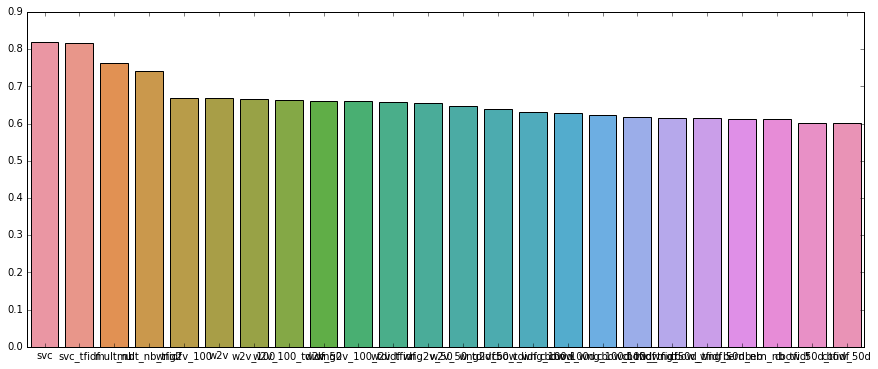

In [46]:
scores = sorted([(name, cross_val_score(model, X, y, cv=3).mean()) 
                 for name, model in all_models], 
                key=lambda (_, x): -x)
print tabulate(scores, floatfmt=".4f", headers=("model", 'score'))

#Plot1
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(15, 6))
sns.barplot(x=[name for name, _ in scores], y=[score for _, score in scores])

Realizar testes variando o tamanho do conjunto de treinamento

In [ ]:
from sklearn.cross_validation import StratifiedShuffleSplit

def benchmark(model, X, y, n):
    test_size = 1 - (n / float(len(y)))
    scores = []
    for train, test in StratifiedShuffleSplit(y, n_iter=5, test_size=test_size):
        for t in train: print type(t)
        print X[train]
        X_train, X_test = X[train], X[test]
        y_train, y_test = y[train], y[test]
        scores.append(accuracy_score(model.fit(X_train, y_train).predict(X_test), y_test))
    return np.mean(scores)

In [ ]:
train_sizes = [10, 40, 160, 640, 3200]
table = []
for name, model in all_models:
    for n in train_sizes:
        table.append({'model': name, 
                      'accuracy': benchmark(model, X, y, n), 
                      'train_size': n})
df = pd.DataFrame(table)


Plotar gráfico

In [ ]:
plt.figure(figsize=(15, 6))
fig = sns.pointplot(x='train_size', y='accuracy', hue='model', 
                    data=df[df.model.map(lambda x: x in ["mult_nb", "svc_tfidf", "w2v_tfidf", 
                                                         "glove_small_tfidf", "glove_big_tfidf", 
                                                        ])])
sns.set_context("notebook", font_scale=1.5)
fig.set(ylabel="accuracy")
fig.set(xlabel="labeled training examples")
fig.set(title="R8 benchmark")
fig.set(ylabel="accuracy")